In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.optimize import brute, minimize, fmin

import ROOT
from find_SN_dir import *

from tqdm import tqdm, trange

Welcome to JupyROOT 6.26/00


In [2]:
pickle_path = "/media/linux_store/hep/data/pickles/event_pools.pkl"
ES_param = load_pdf_parameterized("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf_param.dat", name="ES")
ES_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf.dat", name="ES")
CC_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/CC_gvkm_radiological_0201_pdf.dat", name="CC")

### Load in event pool
either by reading the root files, or reading pickle files (faster)

In [3]:
# directory = "/media/linux_store/hep/data/SN_radio/SN_ana_radiological/"



# ES_event_pool = load_SN_file("/media/linux_store/hep/data/ES_gvkm/ES_gvkm_radiological_0201.root",
#                              with_radio=True, return_nu_dir=True, show_progress=True)
# CC_event_pool = load_SN_file("/media/linux_store/hep/data/CC_gvkm/CC_gvkm_radiological_0201.root",
#                              with_radio=True, return_nu_dir=True, show_progress=True)



In [ ]:
## Save pool as pickle
# import pickle
# with open(pickle_path, "wb") as f:
#     pickle.dump( [ES_event_pool, CC_event_pool], f)

In [3]:
## Read from pickle
import pickle
with open(pickle_path, "rb") as f:
    [ES_event_pool, CC_event_pool] = pickle.load(f)

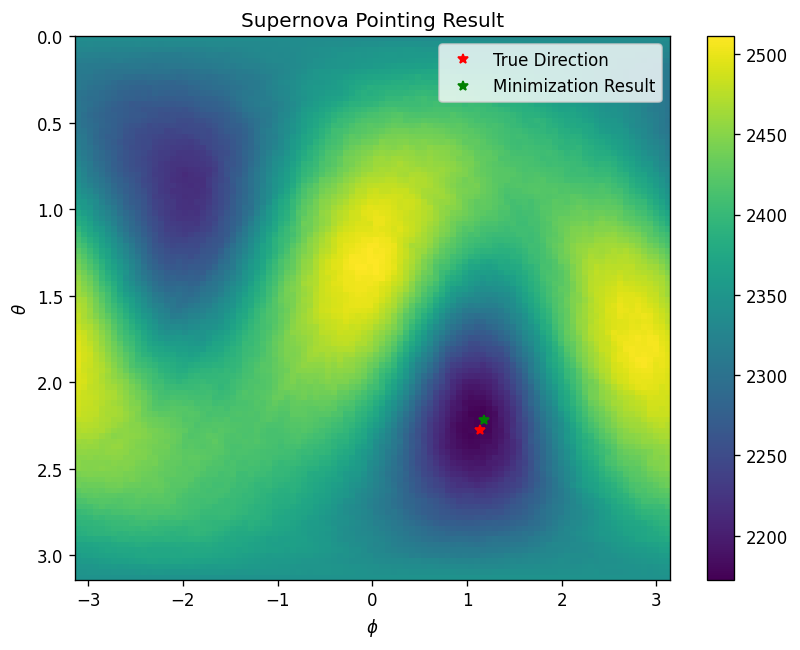

CPU times: user 1 s, sys: 765 ms, total: 1.77 s
Wall time: 6.44 s


3.40927071086025

In [4]:
%%time
confusion_matrix = np.array([[1.0, 0.2], [0.1, 0.8]])
expected_counts = get_expected_counts([326, 3455], confusion_matrix, channel_id_list=[0])
SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                               synthetic=True, with_radio=True, expected_counts=expected_counts)

def loss_func(x):
    return SN_pointer.loss(x)


res = brute(loss_func, ([0, np.pi], [-np.pi, np.pi]), Ns=100, full_output=True, workers=6, finish=None)
# res = minimize(loss, np.array([np.pi/2, 0]), args=args, method = 'Nelder-Mead')
# print(res[0])
# print(SN_pointer.truth_dir)
# print(f"Loss = {loss_func(SN_pointer.truth_dir)}")
details(SN_pointer, res)


In [50]:
import healpy as hp
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

(x0, fval, grid, jout) = res
(theta, phi) = grid
theta = theta.flatten()
phi = phi.flatten()
jout = jout.flatten()

idx = hp.ang2pix(NSIDE, theta, phi)
pixels = np.zeros(NPIX)
pixels[idx] = jout
pixels = hp.smoothing(pixels, fwhm=np.radians(5.))
hp.mollview(pixels, title="Mollview image RING")
hp.projplot(SN_pointer.truth_dir[0], SN_pointer.truth_dir[1], 'rx')
hp.graticule()

ValueError: not enough values to unpack (expected 4, got 2)

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [01:20<00:00,  6.19it/s]


3.797178413721948

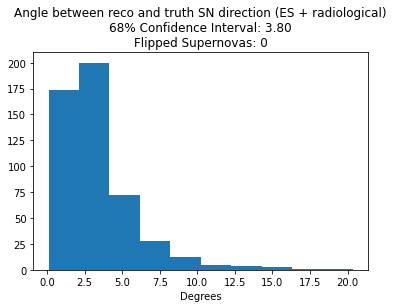

In [6]:
TRIALS=500

errors = []

for _ in trange(TRIALS):
    confusion_matrix = np.array([[1, 0.5], [0, 0.5]])
    expected_counts = get_expected_counts([326, 3455], confusion_matrix, channel_id_list=[0])
    SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                               synthetic=True, with_radio=True, expected_counts=expected_counts)
    def loss_func(x):
        return SN_pointer.loss(x)
    res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=10, 
                full_output=False, workers=6, finish=fmin)
    errors.append(error(SN_pointer, res))

errors = np.asarray(errors)
plt.hist(errors[errors < 90])
plt.title(f"Angle between reco and truth SN direction (ES + radiological)\n68% Confidence Interval: {np.quantile(errors, 0.68):.2f}\nFlipped Supernovas: {errors[errors>90].size}")
plt.xlabel("Degrees")
np.quantile(errors, 0.68)

In [4]:
TRIALS=100

quantiles_list = []
gridpoints = np.arange(0.1, 1.1, 0.1)
for a in gridpoints:
    for b in gridpoints:
        errors = []
        for _ in trange(TRIALS, desc=f"{a = :.2f}, {b = :.2f}"):
            confusion_matrix = np.array([[a, 0.5], [b, 0.5]])
            expected_counts = get_expected_counts([326, 3455], confusion_matrix, channel_id_list=[0])
            SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                                       synthetic=True, with_radio=True, expected_counts=expected_counts)
            def loss_func(x):
                return SN_pointer.loss(x)
            res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=10, 
                        full_output=False, workers=6, finish=fmin)
            errors.append(error(SN_pointer, res))
        quantiles_list.append(np.array([a, b, np.quantile(errors, 0.68)]))

a = 1.00, b = 1.00: 100%|███████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.97s/it]


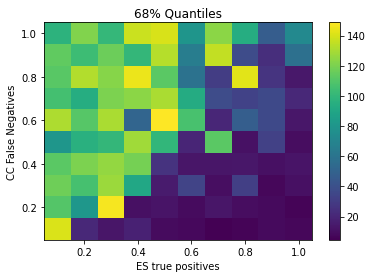

In [5]:
from matplotlib.colors import LogNorm

quantiles_list = np.array(quantiles_list)
x = quantiles_list[:, 0]
y = quantiles_list[:, 1]
z = quantiles_list[:, 2]
# x=np.unique(x)
# y=np.unique(y)
dim = len(gridpoints)
X = x.reshape(dim,dim)
Y = y.reshape(dim,dim)

Z=z.reshape(dim, dim)

plt.pcolormesh(X, Y, Z)
plt.colorbar()
plt.title('68% Quantiles')
plt.xlabel(r'ES true positives')
plt.ylabel(r'CC False Negatives')
plt.show()


b = 0.80: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [08:42<00:00, 104.56s/it]


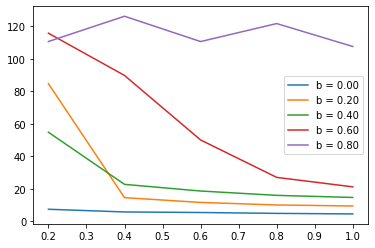

In [49]:
# Test efficiency
TRIALS=50

for b in np.arange(0, 1, 0.2):
    efficiency_quantiles_list = []
    confusion_matrix = np.array([[1.0, 0.5], [b, 0.5]])
    errors = []
    for efficiency in tqdm(np.arange(0.2, 1.1, 0.2), desc=f"b = {b:.2f}"):
        for _ in range(TRIALS):

            expected_counts = get_expected_counts([326, 3455], confusion_matrix*efficiency, channel_id_list=[0])
            SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                                       synthetic=True, with_radio=True, expected_counts=expected_counts)
            def loss_func(x):
                return SN_pointer.loss(x)
            res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=10, 
                        full_output=False, workers=6, finish=fmin)
            errors.append(error(SN_pointer, res))
        efficiency_quantiles_list.append(np.array([efficiency, np.quantile(errors, 0.68)]))
    efficiency_quantiles_list = np.array(efficiency_quantiles_list)
    plt.plot(efficiency_quantiles_list[:, 0], efficiency_quantiles_list[:, 1], label=f"b = {b:.2f}")
    
plt.legend()
plt.show()

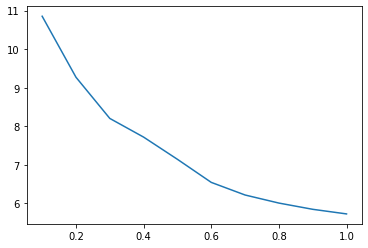

In [22]:
efficiency_quantiles_list = np.array(efficiency_quantiles_list)
plt.plot(efficiency_quantiles_list[:, 0], efficiency_quantiles_list[:, 1])
plt.show()